In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
import os

from script.curate_training_test_data import  curate_training_test_data_many
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [ ]:
df_all = pd.read_csv('eua_price_data_High_Low.csv', thousands=',') 
df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')  
df_all = df_all.sort_values(by = 'Date', ascending=True).reset_index(drop = True)
df_all = df_all[df_all['Date'] > pd.to_datetime('2020-11-24')].reset_index(drop=True)

In [ ]:
from script.generate_gru_pytorch_multistep import train_gru_multi_step, generate_gru_multi_step
import torch 

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predictors_lst =['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean','High_price', 'Low_price']
test_date = '2018-08-01'

sequence_length = 28

original_EUA = df_all['EUA'].values  
dates = df_all['Date'].values
last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
X_train, y_train, X_test, y_test, scaler = curate_training_test_data_many(
                                            df_all, 
                                            flatten=False,
                                            sequence_length_input=28,  # 입력 시퀀스 길이 (30일)
                                            sequence_length_out=28,  # 입력 시퀀스 길이 (30일)
                                            test_date=test_date,
                                            predictors_lst=predictors_lst,
                                            dtype = 'float32',
                                            is_test_split = False,
                                        )

checkpoint_path = "best_mutlistep_gru.pth"
# Convert to PyTorch tensor
X_train_tensor, y_train_tensor = torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device)
model = generate_gru_multi_step(X_train_tensor, y_train_tensor, device)
if os.path.isfile(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
else:
    history = train_gru_multi_step(model, checkpoint_path, 
                                    X_train_tensor, y_train_tensor, 
                                    patience=500,
                                    batch_size=128, epochs=500, verbose=0)
    
# with open('lstm_hist.pkl', 'wb') as f:
#     pickle.dump(history,f)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1



In [21]:
# ## visualize loss curve plot
# plt.figure(figsize=(10, 5))
# plt.plot(history['train_loss'], label='Training Loss')
# plt.plot(history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# # plt.xlim([0,500])
# plt.title('Training and Validation Loss Over Epochs')
# a = np.array(history['val_loss'])
# plt.axvline(np.where(a == a.min())[0][0], color = 'red')
# plt.minorticks_on()
# plt.grid(which='both', linestyle='--', linewidth=0.5)
# plt.grid(which='minor', linestyle=':', linewidth=0.3)

# plt.legend()
# plt.show()

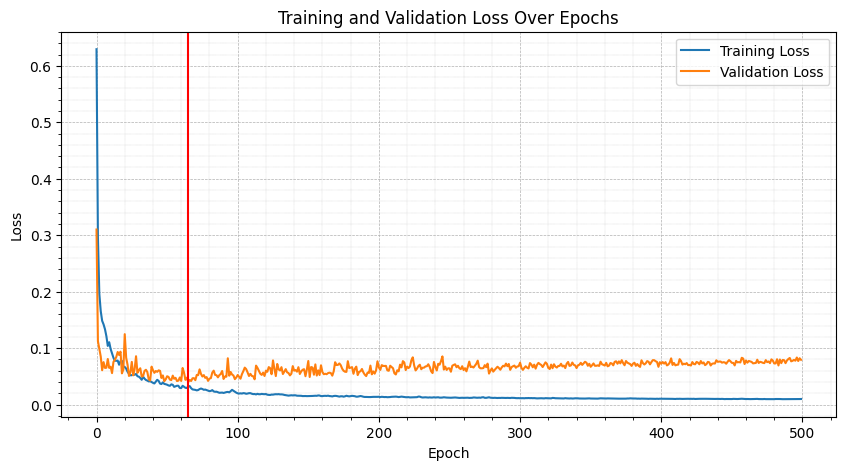

In [7]:
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [22]:
# prediction for train/validation data
train_size = int((1 - 0.05) * X_train_tensor.size(0))
y_train_true, y_test_true = y_train[:train_size], y_train[train_size:]

model.eval()
y_train_pred = model(X_train_tensor[:train_size]).detach().cpu().numpy()
y_test_pred = model(X_train_tensor[train_size:]).detach().cpu().numpy()

y_test_preds = []
model.train()
for i in range(10):
    y_test_preds.append(model(X_train_tensor[train_size:]).detach().cpu().numpy())

In [23]:
from script.post_processing import inverse_scaler_of_all_var
y_train_pred = inverse_scaler_of_all_var(y_train_pred, scaler)
y_test_pred  = inverse_scaler_of_all_var(y_test_pred, scaler)
y_test_preds = inverse_scaler_of_all_var(y_test_preds, scaler)
y_train_true = inverse_scaler_of_all_var(y_train_true, scaler)
y_test_true  = inverse_scaler_of_all_var(y_test_true, scaler)

In [24]:
# define start of train date and valid/train split date
train_start_date =  df_all['Date'][0] + pd.to_timedelta(28, unit = 'day')
train_test_split_date = df_all['Date'][0] + pd.to_timedelta(train_size+28, unit = 'day')

In [19]:
from script.save_permformance import save_perform
model_name ='gru'
save_perform(model_name, y_train_true, y_train_pred, y_test_true, y_test_pred)

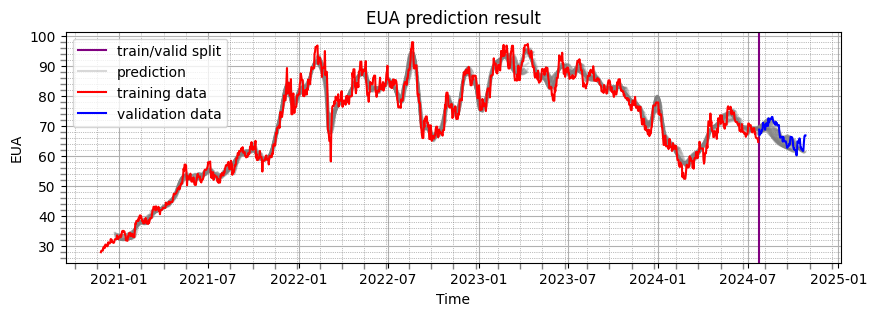

In [25]:
# visuals of train/validation data prediction (single prediction)
from script.post_processing import visual_train_n_valid_data_performance
visual_train_n_valid_data_performance(y_train_pred,y_test_pred, train_start_date, train_test_split_date, df_all,
                                      figsize = (10,3),
                                      decoration = {'xlabel': 'Time', 
                                                    'ylabel':'EUA', 
                                                    'title':'EUA prediction result',
                                                    'grid':'on'})

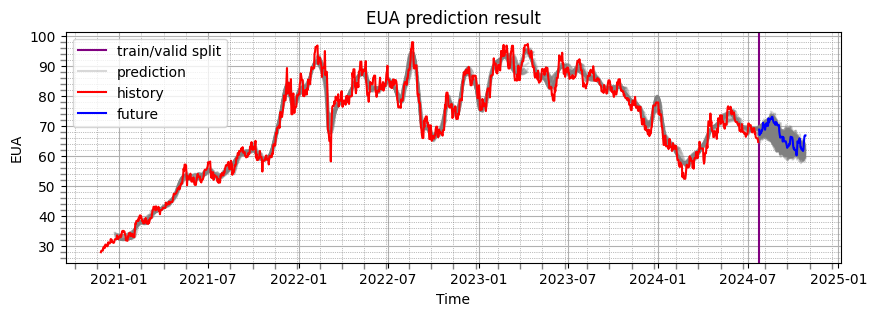

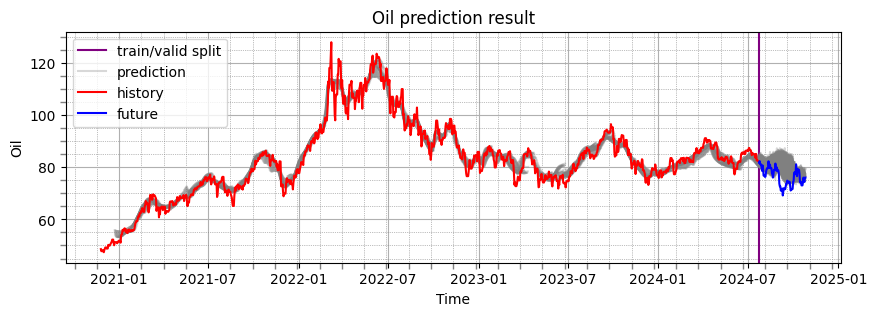

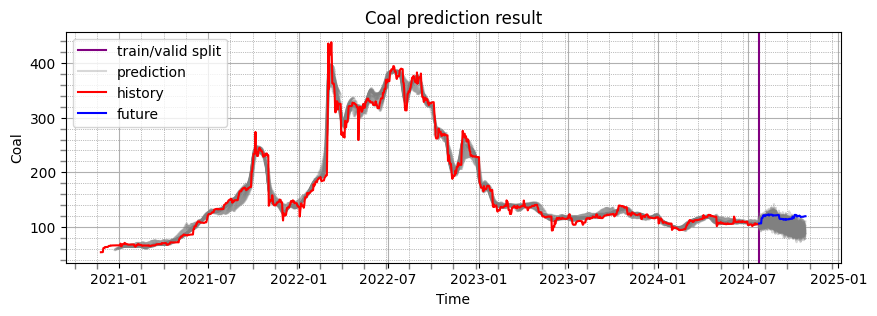

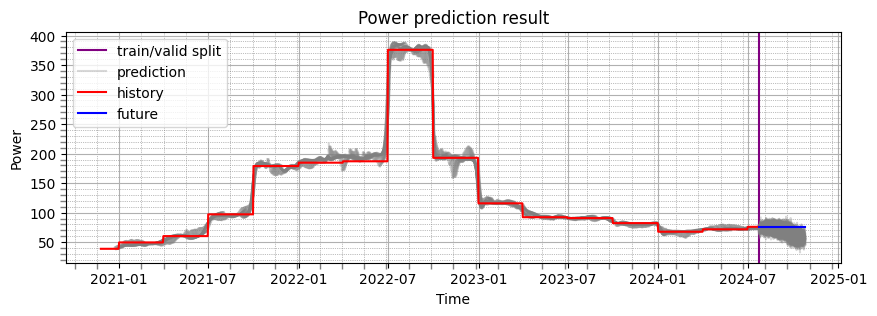

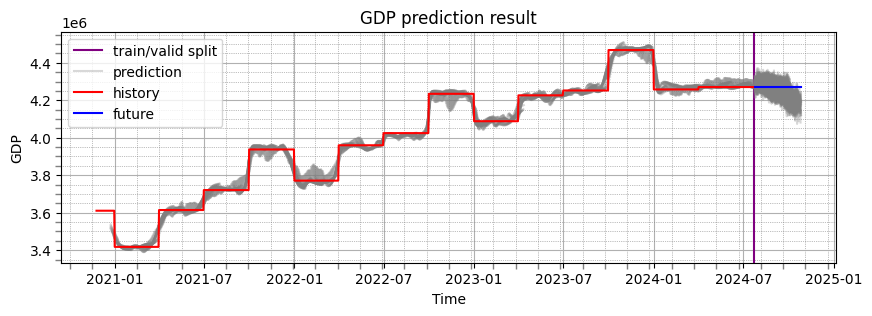

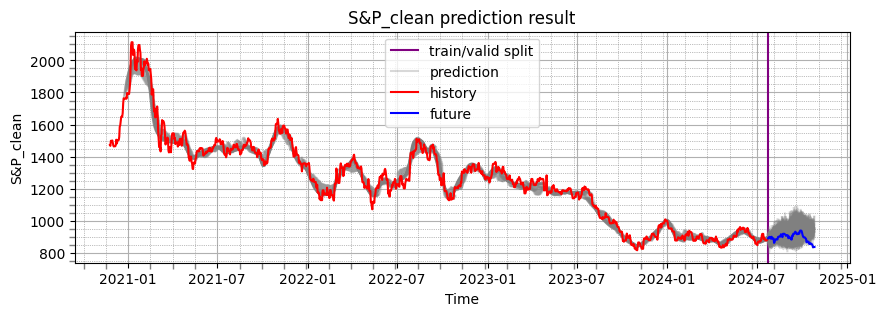

In [14]:
for i, name in enumerate(['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean',]):
    visual_train_n_valid_data_performance(y_train_pred,y_test_preds, train_start_date, train_test_split_date, df_all,
                                        figsize = (10,3),
                                        index_of_data = i,
                                        name_of_data = name,
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':name, 
                                                        'title':f'{name} prediction result',
                                                        'grid':'on'})

In [15]:
from script.generate_lstm_pytorch_multistep import *
import torch 

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predictors_lst =['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean','High_price', 'Low_price']
test_date = '2018-08-01'


if os.path.isdir(folder_name) is not True:
    os.mkdir(folder_name)
modeltype = 'gru_gpu_fin'
sequence_length = 28

original_EUA = df_all['EUA'].values  
dates = df_all['Date'].values
last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
X_train, y_train, X_test, y_test, scaler = curate_training_test_data_many(
                                            df_all, 
                                            flatten=False,
                                            sequence_length_input=28,  # 입력 시퀀스 길이 (30일)
                                            sequence_length_out=28,  # 입력 시퀀스 길이 (30일)
                                            test_date=test_date,
                                            predictors_lst=predictors_lst,
                                            dtype = 'float32',
                                            is_test_split = False,
                                        )

checkpoint_path = f"./{folder_name}/{modeltype}_ts_{sequence_length}.pth"
# Convert to PyTorch tensor
X_train_tensor, y_train_tensor = torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device)
model = generate_lstm_multi_step(X_train_tensor, y_train_tensor)
if os.path.isfile('best_mutistep_lstm_model_fin.pth'):
    model.load_state_dict(torch.load('best_mutistep_lstm_model_fin.pth'))
else:
    history = train_lstm_multi_step(model, checkpoint_path, 
                                    X_train_tensor, y_train_tensor,
                                    validation_split = 0.001, 
                                    patience=500,
                                    batch_size=128, epochs=500, verbose=0)
    
# with open('lstm_hist.pkl', 'wb') as f:
#     pickle.dump(history,f)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


flag == 0
Epoch 2/500, Train Loss: 0.07349157825974394, Val Loss: 0.4870834946632385
flag == 1
Epoch 3/500, Train Loss: 0.0470094924623316, Val Loss: 0.47568511962890625
flag == 2
Epoch 4/500, Train Loss: 0.03616826076152896, Val Loss: 0.3034202456474304
flag == 3
Epoch 5/500, Train Loss: 0.027144101040422423, Val Loss: 0.2548239231109619
flag == 4
Epoch 6/500, Train Loss: 0.023672175308889595, Val Loss: 0.15893034636974335
flag == 5
Epoch 7/500, Train Loss: 0.020930999689850925, Val Loss: 0.09902575612068176
flag == 6
Epoch 8/500, Train Loss: 0.018844539961539022, Val Loss: 0.07136809825897217
flag == 7
Epoch 9/500, Train Loss: 0.017098636050854835, Val Loss: 0.06468892097473145
flag == 8
Epoch 10/500, Train Loss: 0.016120822961665383, Val Loss: 0.05571003258228302
flag == 9
Epoch 11/500, Train Loss: 0.01536461292219556, Val Loss: 0.05474979802966118
flag == 10
Epoch 12/500, Train Loss: 0.014631177768234378, Val Loss: 0.0509442538022995
flag == 11
Epoch 13/500, Train Loss: 0.013956576

In [ ]:
# model.load_state_dict(torch.load(checkpoint_path))

In [16]:
# 2. add recursive scheme
from script.post_processing import resursive_furture_prediction, resursive_furture_prediction_with_dropout
model.train()
future_price_ensemble, future_time = resursive_furture_prediction_with_dropout(model, X_train_tensor[-1],
                                                         train_test_split_date = df_all['Date'].max(),
                                                         num_of_ensemble = 100,
                                                         scaler = scaler,
                                                         df_all = df_all)

In [17]:
from script.post_processing import visual_recursive_future_prediction, visual_recursive_future_prediction_plotly
visual_recursive_future_prediction_plotly(future_time, future_price_ensemble,
                                       train_test_split_date,
                                       df_all,
                                          # figsize = (10,3),
                                          index_of_data= 0, # 0 is EUA price
                                          name_of_data = 'EUA',
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':'EUA', 
                                                        'title':'EUA prediction result',
                                                        'grid':'on'})
                                          

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



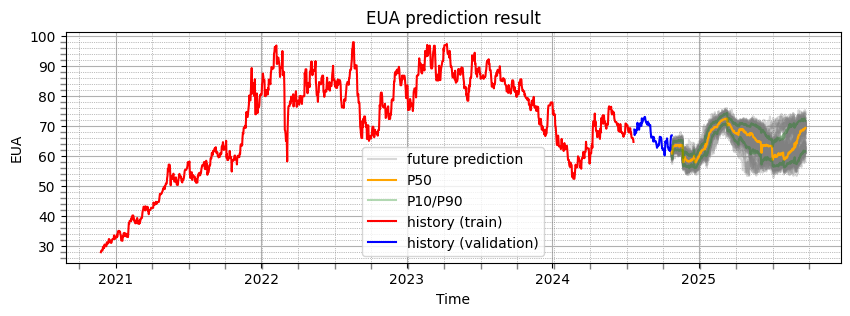

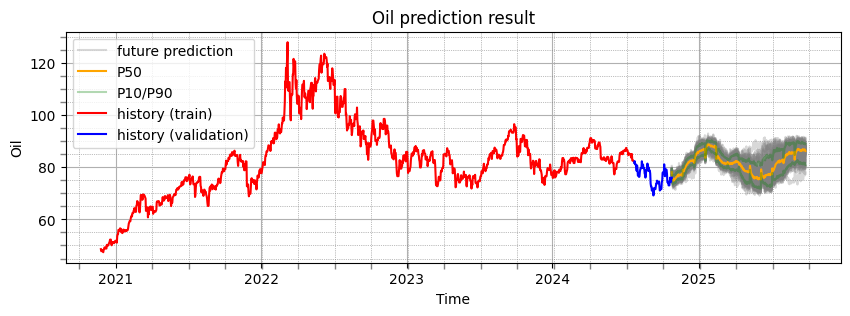

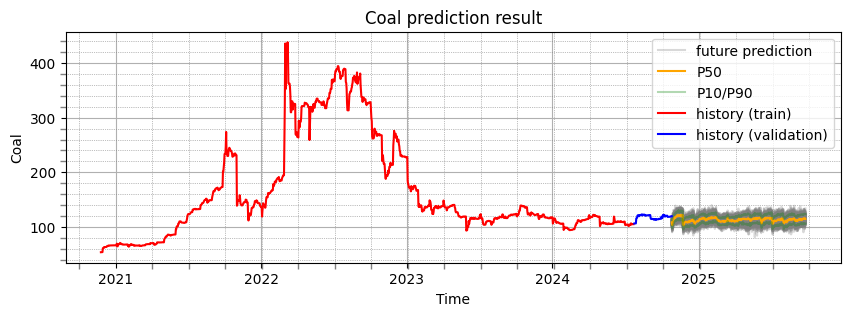

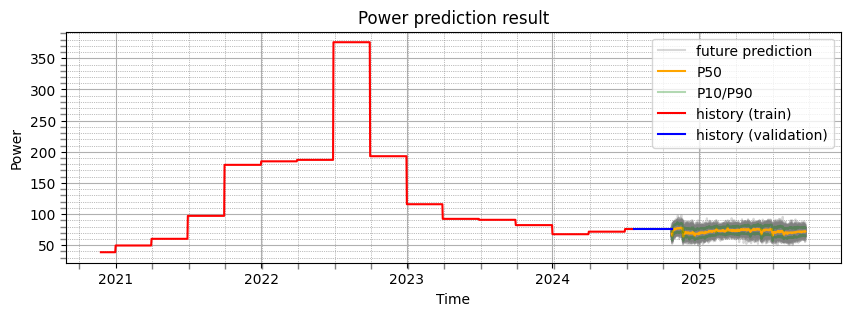

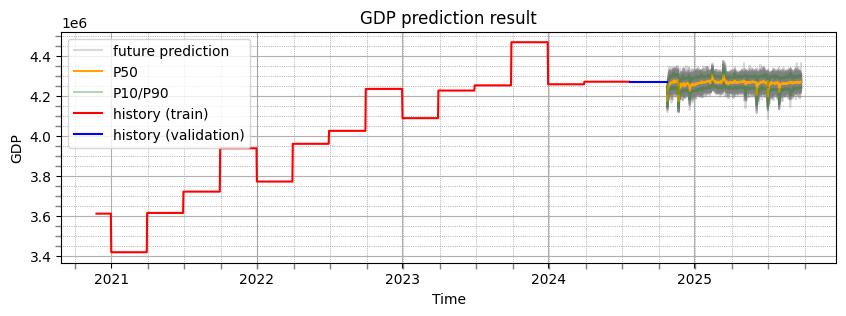

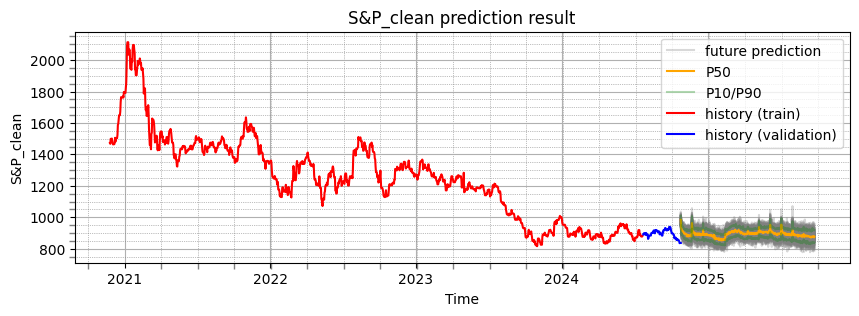

In [18]:
for i, name in enumerate(['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean',]):
    visual_recursive_future_prediction(future_time, future_price_ensemble,
                                       train_test_split_date,
                                       df_all,
                                          figsize = (10,3),
                                          index_of_data= i, # 0 is EUA price
                                          name_of_data = name,
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':name, 
                                                        'title':f'{name} prediction result',
                                                        'grid':'on'})
                                          